# Feature Engineering and Model Selection (Regression)

*Disclaimer: The information provided in this analysis of AAPL, GOOG, AMZN, and MSFT financial data is for educational purposes only and should not be considered as financial advice. The results and insights presented may not accurately reflect future performance, and investing in these stocks involves significant risk. It is strongly recommended to consult with a qualified financial advisor before making any investment decisions.*

#### Download Stock Price Data

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# List of stocks
tickers = ['AAPL', 'GOOG', 'AMZN', 'MSFT']

# Download historical stock price data
stock_data = yf.download(tickers, start="2015-01-01", end="2024-01-01", group_by='ticker')

[*********************100%***********************]  4 of 4 completed


### Feature Engineering

Define the Feature Engineering Function

In [2]:
def feature_engineering(data):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    data = data.copy()

    # Daily returns
    data['Daily Return'] = data['Close'].pct_change()

    # Moving averages
    data['MA20'] = data['Close'].rolling(window=20).mean()  # 20-day moving average
    data['MA50'] = data['Close'].rolling(window=50).mean()  # 50-day moving average

    # Volatility measures
    data['Volatility'] = data['Daily Return'].rolling(window=20).std()  # 20-day rolling std deviation

    # Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    data['Upper Band'] = data['MA20'] + (data['Volatility'] * 2)  # Upper band
    data['Lower Band'] = data['MA20'] - (data['Volatility'] * 2)  # Lower band

    return data


Apply Feature Engineering to Each Stock's Data

In [3]:
# Initialize an empty DataFrame to hold the processed data
processed_data = {}

# Apply feature engineering to each stock's data
for ticker in tickers:
    processed_data[ticker] = feature_engineering(stock_data[ticker])


#### Visualize the Results

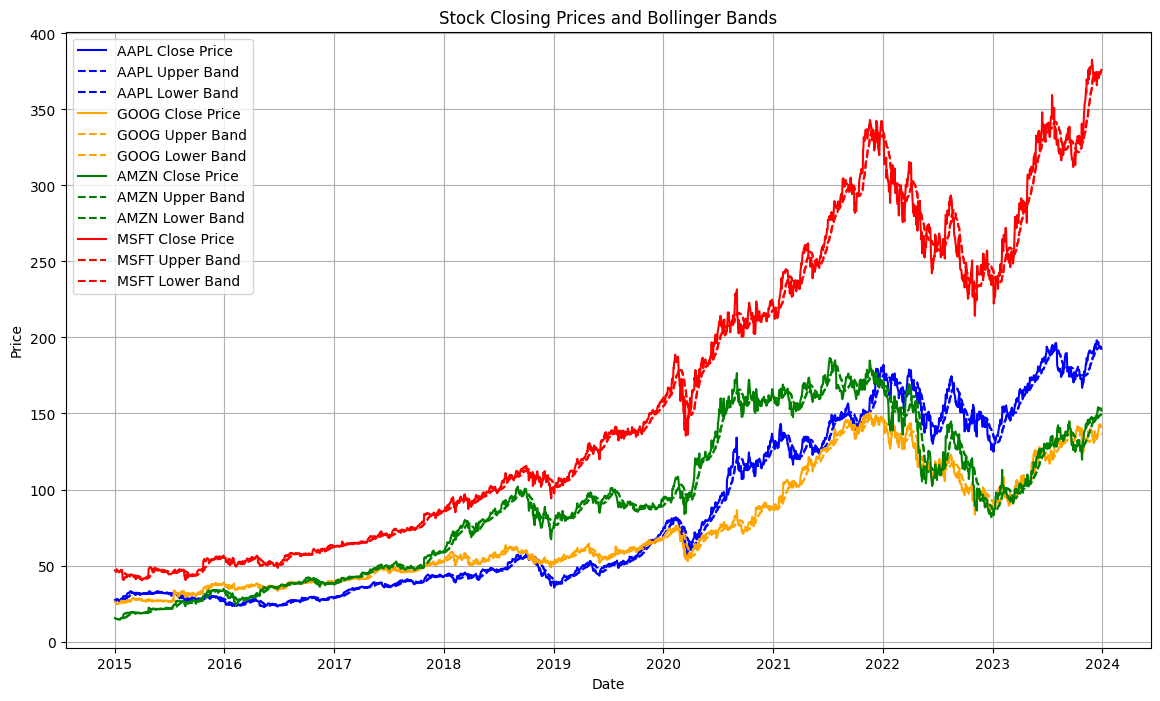

In [4]:
# Plot closing prices and Bollinger Bands for AAPL, MSFT, GOOG, and AMZN
plt.figure(figsize=(14, 8))

# Define colors for each stock
colors = {
    'AAPL': 'blue',
    'AMZN': 'green',
    'GOOG': 'orange',
    'MSFT': 'red'
}

# Loop through each stock ticker to plot
for ticker in tickers:
    plt.plot(processed_data[ticker]['Close'], label=f'{ticker} Close Price', color=colors[ticker])
    plt.plot(processed_data[ticker]['Upper Band'], label=f'{ticker} Upper Band', color=colors[ticker], linestyle='--')
    plt.plot(processed_data[ticker]['Lower Band'], label=f'{ticker} Lower Band', color=colors[ticker], linestyle='--')
    plt.fill_between(processed_data[ticker].index,
                     processed_data[ticker]['Upper Band'],
                     processed_data[ticker]['Lower Band'],
                     color=colors[ticker], alpha=0.1)

plt.title('Stock Closing Prices and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


### Model Selection (Regression)

- KNN Regressor
- Decision Tree Regressor
- SVR
- Linear Regression

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

Initialize a dictionary to hold the metrics for each stock's model

In [6]:
# Initialize a dictionary to hold the metrics for each stock's model
metrics = {}

Loop Through Each Stock, prepare data, and train models

In [7]:
# Loop through each stock, prepare data, and train models
for ticker in tickers:
    # Select the processed data for the current stock
    stock_data = processed_data[ticker].dropna()

    # Features and target variable
    X = stock_data[['MA20', 'MA50', 'Volatility', 'RSI']].dropna()
    y = stock_data['Close'].loc[X.index]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'KNN': KNeighborsRegressor(),
        'SVM': SVR(),
        'Decision Tree': DecisionTreeRegressor(),
        'Linear Regression': LinearRegression()
    }

    # Store metrics for the current stock
    metrics[ticker] = {}

    # Train and evaluate models
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)

        # Store metrics for the current model
        metrics[ticker][model_name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae
        }


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

Print Results for each Stocks

In [8]:
# Print the results for each stock
for ticker, model_metrics in metrics.items():
    print(f"\nMetrics for {ticker}:")
    for model_name, metric_values in model_metrics.items():
        print(f"{model_name} - MSE: {metric_values['MSE']:.4f}, RMSE: {metric_values['RMSE']:.4f}, MAE: {metric_values['MAE']:.4f}")


Metrics for AAPL:
KNN - MSE: 11.9221, RMSE: 3.4528, MAE: 2.4045
SVM - MSE: 39.9751, RMSE: 6.3226, MAE: 3.9846
Decision Tree - MSE: 4.3566, RMSE: 2.0872, MAE: 1.2717
Linear Regression - MSE: 8.6909, RMSE: 2.9480, MAE: 2.2157

Metrics for GOOG:
KNN - MSE: 4.7467, RMSE: 2.1787, MAE: 1.4664
SVM - MSE: 14.6769, RMSE: 3.8310, MAE: 2.2511
Decision Tree - MSE: 3.8305, RMSE: 1.9572, MAE: 1.1912
Linear Regression - MSE: 4.5291, RMSE: 2.1282, MAE: 1.5712

Metrics for AMZN:
KNN - MSE: 10.6048, RMSE: 3.2565, MAE: 2.3252
SVM - MSE: 47.2335, RMSE: 6.8727, MAE: 4.1166
Decision Tree - MSE: 8.1405, RMSE: 2.8532, MAE: 1.6799
Linear Regression - MSE: 11.8960, RMSE: 3.4491, MAE: 2.4707

Metrics for MSFT:
KNN - MSE: 33.2231, RMSE: 5.7639, MAE: 4.0678
SVM - MSE: 262.7355, RMSE: 16.2091, MAE: 10.0993
Decision Tree - MSE: 17.2686, RMSE: 4.1555, MAE: 2.4085
Linear Regression - MSE: 21.4699, RMSE: 4.6336, MAE: 3.5120


#### Model Performance Metrics for Stock Prediction

<ipython-input-9-b9ea58b49a43>:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metrics_melted, x='Stock', y='Value', hue='Model', ci=None)


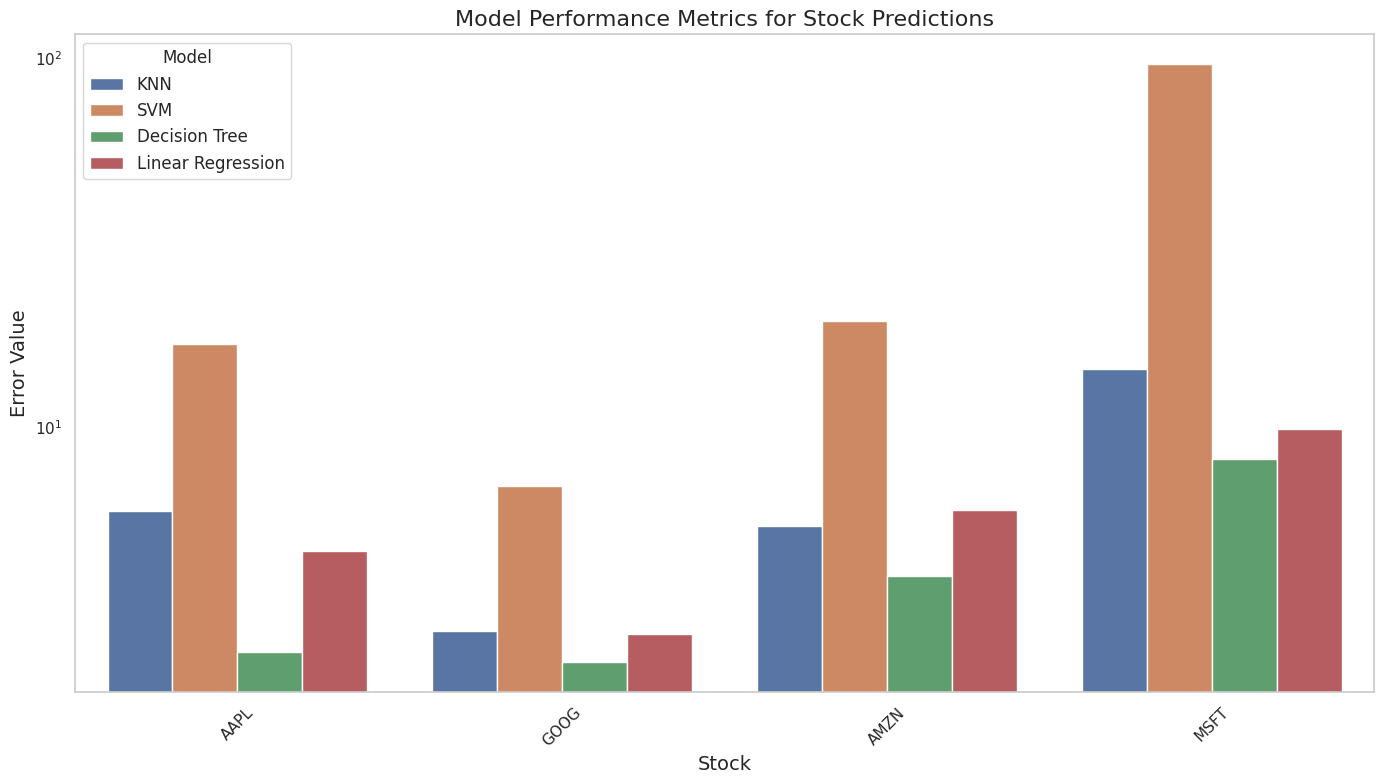

In [9]:
# Define the metrics data
metrics_data = {
    'Stock': ['AAPL', 'AAPL', 'AAPL', 'AAPL',
              'GOOG', 'GOOG', 'GOOG', 'GOOG',
              'AMZN', 'AMZN', 'AMZN', 'AMZN',
              'MSFT', 'MSFT', 'MSFT', 'MSFT'],
    'Model': ['KNN', 'SVM', 'Decision Tree', 'Linear Regression',
              'KNN', 'SVM', 'Decision Tree', 'Linear Regression',
              'KNN', 'SVM', 'Decision Tree', 'Linear Regression',
              'KNN', 'SVM', 'Decision Tree', 'Linear Regression'],
    'MSE': [11.9221, 39.9751, 4.0966, 8.6909,
            4.7467, 14.6769, 3.7877, 4.5291,
            10.6048, 47.2335, 7.4695, 11.8960,
            33.2231, 262.7355, 17.9715, 21.4699],
    'RMSE': [3.4528, 6.3226, 2.0240, 2.9480,
             2.1787, 3.8310, 1.9462, 2.1282,
             3.2565, 6.8727, 2.7330, 3.4491,
             5.7639, 16.2091, 4.2393, 4.6336],
    'MAE': [2.4045, 3.9846, 1.2081, 2.2157,
            1.4664, 2.2511, 1.1723, 1.5712,
            2.3252, 4.1166, 1.6084, 2.4707,
            4.0678, 10.0993, 2.4084, 3.5120]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Set the style of the visualization
sns.set(style="whitegrid")

# Plotting the metrics
plt.figure(figsize=(14, 8))

# Melt the DataFrame to plot multiple metrics
metrics_melted = metrics_df.melt(id_vars=['Stock', 'Model'],
                                   value_vars=['MSE', 'RMSE', 'MAE'],
                                   var_name='Metric',
                                   value_name='Value')

# Create the bar plot
sns.barplot(data=metrics_melted, x='Stock', y='Value', hue='Model', ci=None)

# Add titles and labels
plt.title('Model Performance Metrics for Stock Predictions', fontsize=16)
plt.ylabel('Error Value', fontsize=14)
plt.xlabel('Stock', fontsize=14)
plt.legend(title='Model', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log')  # Log scale for better visualization due to large value range
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()
